<a href="https://colab.research.google.com/github/anasruzh/ML_RSM_ARR/blob/anas_primera_entrega_bulling/ejercicio1_bullying1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

El acoso escolar, o *bullying*, constituye uno de los desafíos más relevantes en el ámbito educativo contemporáneo. Este fenómeno se caracteriza por conductas repetidas de intimidación, humillación o agresión, ejercidas intencionadamente hacia un estudiante que percibe dificultad para defenderse. Sus consecuencias abarcan desde el deterioro del bienestar emocional, la ansiedad o la depresión, hasta el aislamiento social, bajo rendimiento académico e incluso riesgo de abandono escolar.

A nivel europeo, el problema tiene una magnitud considerable. De acuerdo con datos recientes de la Oficina Regional de la Organización Mundial de la Salud (OMS Europa), aproximadamente **11 % de los adolescentes han sido víctimas de acoso** tradicional en la escuela y cerca del 15 % han experimentado ciberacoso. Estas cifras reflejan un incremento asociado al uso intensivo de dispositivos digitales y redes sociales, especialmente desde la pandemia.

En el contexto español, los datos indican una situación igualmente preocupante. Informes educativos nacionales reflejan que alrededor del 24 % de los estudiantes identifica episodios de acoso en su centro escolar durante el último curso académico. Estudios sistemáticos sitúan la prevalencia real en torno al 11,45 %, con mayor incidencia en formas verbales, relacionales y psicológicas, que suelen resultar menos visibles que las agresiones físicas. Además, las víctimas de acoso presentan mayores niveles de ansiedad, estrés, deterioro socioemocional y menor participación escolar.

Estas cifras ponen de manifiesto que el bullying no es un hecho aislado, sino un problema estructural que requiere una actuación coordinada por parte de los centros educativos, familias, profesionales de la salud y administraciones públicas. La prevención y la intervención eficaz dependen de identificar tempranamente las señales, promover una cultura de convivencia positiva y diseñar programas basados en la evidencia.

El presente informe analiza la situación del acoso escolar  a partir de datos actuales, examina los factores asociados, evalúa su impacto emocional y educativo, y propone líneas de actuación que contribuyan a reducir su incidencia y favorecer entornos escolares seguros e inclusivos.

# 1. Importación de librerías y generación de la semilla 

In [1]:
# ==============================================
# PROYECTO: Detección de Bullying Escolar
#Ejercicio 1
# ==============================================



#  1. Importación de librerías
import pandas as pd
import numpy as np
import sklearn
import numpy as np
import random
import os
import sys, platform
import matplotlib

# generación de la semilla

SEED = 42

# Semilla global
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Métricas de evaluación
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Manejo del desbalanceo
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Versiónes
print({
    'python': sys.version.split()[0],
    'os': platform.platform(),
    'pandas': pd.__version__,
    'numpy': np.__version__,
    'scikit-learn': sklearn.__version__,
    'matplotlib': matplotlib.__version__
})



{'python': '3.13.2', 'os': 'Windows-10-10.0.19045-SP0', 'pandas': '2.3.3', 'numpy': '2.3.5', 'scikit-learn': '1.7.2', 'matplotlib': '3.10.7'}


# 2. Carga de datos (bullying1.csv)
Comenzamos cargando el dataset y estableciendo la variable objetivo, en este caso será "sufre_bullying"

In [2]:

df = pd.read_csv("Bullying1.csv")

# Variable objetivo
target_col = "Sufre_Bullying"

# 3. Limpieza y codificación de la variable objetivo

En este paso transformamos la variable objetivo “sufre_bullying” a un formato numérico binario (0/1).
Esto es necesario porque los modelos de Machine Learning solo pueden trabajar con números.

In [3]:

# 3.1 Convertimos la variable objetivo a 0/1
df[target_col] = df[target_col].astype(str).str.strip().str.lower().map({
    "si": 1, "sí": 1, "s": 1, "yes": 1, "true": 1, "1": 1,
    "no": 0, "n": 0, "false": 0, "0": 0
})

In [4]:

# 3.2 Separación de variables predictoras y objetivo

X = df.drop(columns=[target_col])
y = df[target_col]


In [5]:

# 3.3 Identificación y separación de variables numéricas y categóricas

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X.describe()

,Edad,Horas_Sueno,Notas_Promedio,Numero_Amigos,Tiempo_Videojuegos,Tiempo_Redes,Actividades_Extracurr,Ausencias_Escolares,Autoestima,Ansiedad,Depresion,Conflictos_Familiares,Tiempo_Internet,Actividad_Fisica
count,1900.000000,2000.000000,2000.000000,1900.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,14.478947,7.010350,4.951950,6.878421,2.921400,4.946450,2.020000,14.523500,6.456264,6.410275,4.878950,4.514500,6.022200,3.544050
std,1.718186,1.714826,2.870945,4.283337,1.720919,2.843097,1.413718,8.633059,6.854294,6.788385,2.910039,2.822193,3.467883,2.043938
min,12.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,5.500000,2.500000,3.000000,1.400000,2.500000,1.000000,7.000000,2.700000,2.700000,2.300000,2.000000,3.100000,1.800000
50%,14.000000,7.100000,4.900000,7.000000,2.900000,4.900000,2.000000,15.000000,5.300000,5.200000,4.900000,4.000000,5.900000,3.550000
75%,16.000000,8.500000,7.500000,11.000000,4.400000,7.300000,3.000000,22.000000,7.900000,7.900000,7.400000,7.000000,9.100000,5.300000
max,17.000000,10.000000,10.000000,14.000000,6.000000,10.000000,4.000000,29.000000,33.739279,33.402491,10.000000,9.000000,12.000000,7.000000


# 4. División del dataset en entrenamiento y test

Se separaron las variables predictoras y la variable objetivo en dos subconjuntos: entrenamiento (80%) y test (20%). Se utilizó una división estratificada para mantener la proporción original de clases y un valor fijo de random_state para garantizar la reproducibilidad de los resultados.


In [6]:

#División en entrenamiento y test (80/20)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# 5. Evitar el overfitting 

Una vez realizada la separación del conjunto de datos en entrenamiento y prueba (train/test), procedemos a definir y entrenar el modelo de Random Forest. En este punto es donde se configuran los hiperparámetros, ya que son los valores que determinan cómo aprende el modelo a partir de los datos de entrenamiento, y deben fijarse antes de entrenarlo.

En este proyecto se utilizaron los siguientes hiperparámetros principales:

* n_estimators = 300: indica el número de árboles que tendrá el bosque. Un número mayor suele mejorar la estabilidad y la capacidad predictiva del modelo, al reducir la varianza del conjunto.

* min_samples_split = 10: establece el número mínimo de muestras necesarias para dividir un nodo. Valores más altos evitan que el modelo cree divisiones demasiado específicas y ayudan a prevenir el sobreajuste.

* min_samples_leaf = 4: define el mínimo de muestras que debe contener una hoja. Esto fuerza a los árboles a ser menos profundos y más generalistas, lo que también reduce el riesgo de sobreajuste.

* class_weight = 'balanced': ajusta automáticamente los pesos de las clases según su frecuencia. En un problema desbalanceado como el del acoso escolar, este parámetro ayuda al modelo a prestar más atención a la clase minoritaria, mejorando su capacidad de detección.

Estos hiperparámetros se aplican después de generar el train/test porque el modelo debe configurarse antes del entrenamiento, pero con los datos correctamente separados para evitar fugas de información. Con esta configuración, el Random Forest aprende de manera más estable, evita el sobreajuste y mejora su capacidad para identificar casos de bullying dentro de un conjunto de datos desequilibrado.

Es importante destacar que estos *parámetros son específicos del Random Forest* y no se aplican de la misma forma a otros modelos, como la Regresión Logística. Cada algoritmo tiene sus propios hiperparámetros y sus propias estrategias para controlar la complejidad y el peso de las clases. Por ejemplo, la Regresión Logística también permite usar class_weight='balanced', pero no utiliza parámetros como n_estimators o min_samples_leaf, que solo existen en modelos basados en árboles

In [7]:
min_samples_split=10  
min_samples_leaf=4  
n_estimators=300  
class_weight='balanced'

En el proyecto se incorporan varias medidas para reducir el **riesgo de overfitting** —es decir, que el modelo aprenda demasiado los detalles del conjunto de entrenamiento y no generalice bien a nuevos datos. En concreto, el código aplica las siguientes estrategias:

1. División train/test (80/20)

Separar los datos en entrenamiento y prueba garantiza que evaluemos el modelo con información que no ha visto durante el entrenamiento, detectando si se sobreajusta.

2. SMOTE aplicado solo al conjunto de entrenamiento

El sobremuestreo se usa únicamente en X_train.
Así evitamos que el modelo “vea” versiones sintéticas de los datos de test y aprenda patrones irreales.

3. Uso de Pipelines

Los pipelines garantizan que todos los pasos del preprocesamiento (imputación, escalado, codificación y SMOTE) se apliquen solo al entrenamiento y no filtren información hacia el test.
Esto evita el data leakage, una de las causas más comunes de overfitting.

4. Regularización implícita en los modelos

Logistic Regression utiliza regularización por defecto (L2), que penaliza modelos demasiado complejos.

Random Forest incorpora hiperparámetros que limitan su complejidad:

min_samples_split=10

min_samples_leaf=4

n_estimators=300 (más árboles → más estabilidad)
Estos valores reducen el riesgo de que los árboles memoricen el conjunto de entrenamiento.

5. Modelos evaluados con varias métricas

El uso de métricas como F1-score, ROC-AUC y matriz de confusión permite detectar si un modelo funciona bien globalmente o si está aprendiendo patrones falsos del train.

# 6. Preprocesamiento de datos 

En este paso aplicamos un proceso de preprocesamiento estructurado para preparar el dataset antes de entrenar los modelos de clasificación. El preprocesamiento es esencial para garantizar que los algoritmos puedan interpretar los datos correctamente y aprendan patrones útiles de manera estable.



In [8]:

# Imputamos valores faltantes y escalamos variables numéricas
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Codificamos variables categóricas con OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combinamos ambos preprocesamientos
preprocess = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

# 7. Aplicamos los modelos

En este apartado se implementaron diferentes modelos de Machine Learning con el objetivo de predecir la probabilidad de que un estudiante sufra bullying. Todos los modelos se integraron dentro de un Pipeline que incluye el preprocesamiento de datos antes del entrenamiento.

Se utilizaron cuatro enfoques:

A) **Regresión Logística (balanced)**

Modelo lineal, interpretable y adecuado como línea base. Se empleó class_weight="balanced" para compensar el desbalance de clases y evitar que el modelo favorezca a la clase mayoritaria.

B) **Random Forest (balanced)**

Modelo de conjunto basado en múltiples árboles de decisión. Se usó también class_weight="balanced" para mejorar la detección de la clase minoritaria. Este algoritmo suele capturar relaciones complejas entre variables y ofrecer mejor rendimiento.

C) **SMOTE + Regresión Logística**

En este caso se incorpora la técnica SMOTE, que genera ejemplos sintéticos de la clase minoritaria para lograr un dataset equilibrado antes del entrenamiento. Esto ayuda a que la Regresión Logística disponga de más información sobre los casos positivos.

D) **SMOTE + Random Forest**

Combina SMOTE con Random Forest para potenciar el aprendizaje de patrones de la clase minoritaria. Es uno de los enfoques más robustos para datasets desbalanceados, ya que mezcla oversampling y un modelo no lineal de alta capacidad.

Cada uno de estos modelos se evaluó posteriormente para comparar su rendimiento y determinar cuál ofrece mejores resultados en la detección del bullying.

In [9]:

# A) Modelo base interpretable: Regresión Logística
logreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# B) Modelo de conjunto (Ensemble): Random Forest
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

# C) Modelo con técnica de balanceo SMOTE + Regresión Logística
logreg_smote = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(max_iter=1000))
])

# D) Modelo con técnica de balanceo SMOTE + Random Forest
rf_smote = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

# 8. Evaluación de modelos y generación de resultados
En este paso se lleva a cabo la evaluación completa de los modelos de Machine Learning utilizados en el estudio. Para ello, se crea un diccionario que contiene todos los modelos entrenados (Regresión Logística, Random Forest, y sus versiones combinadas con SMOTE). Posteriormente, se recorre cada uno de ellos y se realiza el proceso estándar de evaluación:

1. Entrenamiento del modelo con los datos de entrenamiento (modelo.fit(X_train, y_train)).

2. Predicción sobre el conjunto de test tanto de las clases (predict) como de las probabilidades (predict_proba).

3. Obtención del classification report, que incluye métricas como precision, recall y f1-score para cada clase.

4. Cálculo del ROC-AUC, una métrica clave para problemas desbalanceados, que mide la capacidad del modelo para distinguir entre las clases.

5. Generación y visualización de la matriz de confusión, que muestra los aciertos y errores de clasificación.

6. Almacenar todos los resultados en una estructura (resultados.append(...)) para poder compararlos posteriormente.

Este proceso garantiza una evaluación homogénea y justa entre todas las técnicas empleadas, permitiendo identificar qué modelo funciona mejor en la tarea de predecir si un estudiante sufre bullying.


In [10]:

modelos = {
    "Logistic Regression (balanced)": logreg,
    "Random Forest (balanced)": rf,
    "SMOTE + Logistic Regression": logreg_smote,
    "SMOTE + Random Forest": rf_smote
}

resultados = []

for nombre, modelo in modelos.items():
    print(f"\nEntrenando modelo: {nombre}")
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc)
    print("Matriz de confusión:\n", conf_matrix)

    resultados.append({
        "Modelo": nombre,
        "ROC_AUC": roc_auc,
        "Classification_Report": report,
        "Confusion_Matrix": conf_matrix.tolist()
    })



Entrenando modelo: Logistic Regression (balanced)
              precision    recall  f1-score   support

           0       0.77      0.65      0.71       259
           1       0.50      0.65      0.57       141

    accuracy                           0.65       400
   macro avg       0.64      0.65      0.64       400
weighted avg       0.68      0.65      0.66       400

ROC-AUC: 0.7166132698047591
Matriz de confusión:
 [[168  91]
 [ 49  92]]

Entrenando modelo: Random Forest (balanced)
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       259
           1       0.79      0.67      0.73       141

    accuracy                           0.82       400
   macro avg       0.81      0.79      0.80       400
weighted avg       0.82      0.82      0.82       400

ROC-AUC: 0.919261206495249
Matriz de confusión:
 [[234  25]
 [ 46  95]]

Entrenando modelo: SMOTE + Logistic Regression
              precision    recall  f1-score   support

  

## 9. Interpretación de los resultados

1. Logistic Regression (balanced)

Este modelo detecta bastantes casos de bullying (recall 0.65), pero comete muchos falsos positivos. Su capacidad de discriminación (AUC=0.71) es moderada. Es un modelo correcto pero limitado para capturar relaciones complejas

2. Random Forest (balanced)

Modelo más complejo que maneja mejor el desbalance mediante class_weight='balanced'.
Este modelo obtiene un rendimiento claramente superior.
Captura patrones complejos, logra un equilibrio sólido entre precision y recall y presenta una capacidad excelente para distinguir entre ambas clases (AUC=0.92). Es el mejor modelo sin SMOTE.

3. SMOTE + Logistic Regression

SMOTE genera ejemplos sintéticos para balancear el conjunto de entrenamiento.
SMOTE mejora el recall, pero penaliza la precisión.
El modelo sigue siendo limitado para aprender relaciones complejas.

4. SMOTE + Random Forest

Combinación potente: datos balanceados artificialmente + modelo complejo.
Este es el modelo más equilibrado y eficaz:
• Muy buen recall → detecta más casos reales de acoso
• Precisión alta → pocos falsos positivos
• Excelente capacidad discriminativa (AUC≈0.91)

*Es ideal si el objetivo es identificar la mayor cantidad de víctimas reales minimizando errores.*

# **Análisis del dataset tras aplicar las técnicas**

El análisis de los modelos nos permitió entender mejor las características de los datos.
Observamos que el conjunto estaba desbalanceado, es decir, tenía muchos ejemplos de un tipo y pocos del otro. Esto hacía que los modelos iniciales tuvieran dificultades para reconocer los casos menos frecuentes.

Al aplicar técnicas de equilibrio como SMOTE y ajuste de pesos, los modelos mejoraron su capacidad para detectar esos casos minoritarios. Esto demuestra que los datos sí contienen patrones reconocibles, pero que era necesario darles más visibilidad para que el modelo pudiera aprenderlos correctamente.

También notamos que los modelos más complejos, como Random Forest, funcionan mejor que los modelos lineales, lo que sugiere que en el dataset hay relaciones no tan simples entre las variables.

En general, los resultados indican que el conjunto de datos tiene información valiosa y diferenciada, aunque requiere un tratamiento cuidadoso para evitar que la clase mayoritaria domine el aprendizaje del modelo.

# **Evaluación y Comparación de Modelos de Clasificación**

Se evaluaron distintos modelos de clasificación binaria para abordar el desbalance de clases presente en el conjunto de datos. Los modelos probados fueron Regresión Logística y Random Forest, tanto con el ajuste de pesos balanceado (class_weight='balanced') como combinados con la técnica de sobremuestreo SMOTE (Synthetic Minority Over-sampling Technique).

Los resultados muestran que el Random Forest con pesos balanceados obtuvo el mejor desempeño global, alcanzando una exactitud del 82% y un ROC-AUC de 0.92, lo que indica una excelente capacidad de discriminación entre clases. En comparación, la Regresión Logística presentó un rendimiento moderado (ROC-AUC ≈ 0.72), con una tendencia a generar más falsos positivos.

La aplicación de SMOTE mejoró ligeramente el desempeño de los modelos al aumentar el recall de la clase minoritaria, aunque el beneficio fue más notable en el Random Forest, que alcanzó una exactitud del 84% y un ROC-AUC de 0.91.

Las curvas ROC y Precision-Recall confirman visualmente estos resultados: el Random Forest logra una mejor separación entre clases y mantiene un equilibrio adecuado entre precisión y recall. Finalmente, se aplicó un proceso de optimización de hiperparámetros (GridSearchCV) y ajuste del umbral de decisión, con el objetivo de maximizar el F1-score de la clase positiva, mejorando la capacidad del modelo para identificar correctamente los casos minoritarios sin incrementar excesivamente los falsos positivos.

En conclusión, el Random Forest balanceado (con o sin SMOTE) se considera el modelo más robusto y equilibrado para este problema, al ofrecer el mejor compromiso entre precisión, recall y capacidad de generalización

# **Resultados del modelo**

Se probaron distintos métodos para que una computadora aprendiera a predecir entre dos posibles resultados (por ejemplo, si algo pertenece a una categoría o no).

Probamos dos tipos de modelos: uno más simple (Regresión Logística) y otro más complejo (Random Forest), que funciona como un conjunto de muchos “árboles de decisión” que toman decisiones en grupo.

También usamos una técnica llamada SMOTE, que sirve para equilibrar los datos cuando hay muchos ejemplos de una clase y pocos de otra. Es como si “inventáramos” ejemplos similares a los que hay pocos, para que el modelo aprenda mejor a reconocerlos.

Los resultados mostraron que el modelo Random Forest fue el que mejor aprendió.

Acertó en más del 80% de los casos.

Detectó correctamente la mayoría de los casos importantes.

Además, se equivocó menos que los demás modelos.

En resumen, el modelo de Random Forest logró el mejor equilibrio entre aciertos y errores.
Esto significa que, en la práctica, es el que mejor puede predecir los resultados correctos sin confundirse demasiado.

## Optimización del Random Forest

In [11]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Usamos la pipeline de Random Forest que ya incluye el preprocesamiento
# y es definida en el paso 8

# Definir la grilla de hiperparámetros para el paso 'clf' de la pipeline
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2']
}

# La pipeline 'rf' ya está definida en la celda anterior y contiene
# el preprocesamiento y el RandomForestClassifier. Si la sobrescribimos aquí
# no tendremos el preprocesamiento.
# Para usar la pipeline definida en la celda 8, simplemente la referenciamos.
# Asegúrate de que la variable 'rf' usada aquí es la pipeline, no una nueva instancia.
# Si 'rf' fue sobrescrita, deberíamos usar modelos['Random Forest (balanced)']
# o asegurarnos de que la pipeline se usa correctamente.
# Para evitar confusiones, usaremos la pipeline directamente del diccionario 'modelos'.

# Búsqueda con validación cruzada
grid = GridSearchCV(
    modelos["Random Forest (balanced)"], # Usamos la pipeline completa con preprocesamiento
    param_grid,
    scoring='f1',        # puedes usar 'recall' o 'roc_auc'
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print(" Mejor combinación de hiperparámetros:")
print(grid.best_params_)
print(f" Mejor F1-score en CV: {grid.best_score_:.4f}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
 Mejor combinación de hiperparámetros:
{'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10, 'clf__n_estimators': 300}
 Mejor F1-score en CV: 0.7799


Se realizó una búsqueda de hiperparámetros mediante GridSearchCV, evaluando 162 configuraciones distintas del modelo Random Forest con validación cruzada de 5 folds (810 entrenamientos en total). La mejor combinación encontrada fue: n_estimators=300, max_features='sqrt', min_samples_split=10 y min_samples_leaf=4. Esta configuración maximiza el F1-score (0.7799) y ayuda a controlar el overfitting, proporcionando un modelo más estable y generalizable.

In [12]:
#tras encontrar los mejores hipeparametros se hace reentrenamiento
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]


In [13]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = [f1_score(y_test, y_proba > t) for t in thresholds]

best_t = thresholds[np.argmax(f1_scores)]
print(f"Umbral óptimo para F1: {best_t:.2f}")

Umbral óptimo para F1: 0.45


Por defecto, los modelos de clasificación binaria usan un umbral de 0.5 para determinar si un caso pertenece a la clase positiva. Sin embargo, este valor no siempre maximiza el equilibrio entre aciertos y errores.

Se realizó un análisis del F1-score para distintos umbrales de probabilidad, con el fin de identificar el punto que ofreciera el mejor balance entre precisión y recall.
El **umbral óptimo encontrado fue 0.45**, lo que significa que el modelo mejora su capacidad para detectar los casos positivos al reducir ligeramente el punto de corte.

En la práctica, esto indica que el modelo obtiene un mejor equilibrio entre identificar correctamente los casos relevantes (recall) y mantener una buena tasa de aciertos (precisión), resultando en un rendimiento más estable y útil para la aplicación final.

c:\Users\ANASTASIYARUZHYTSKA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


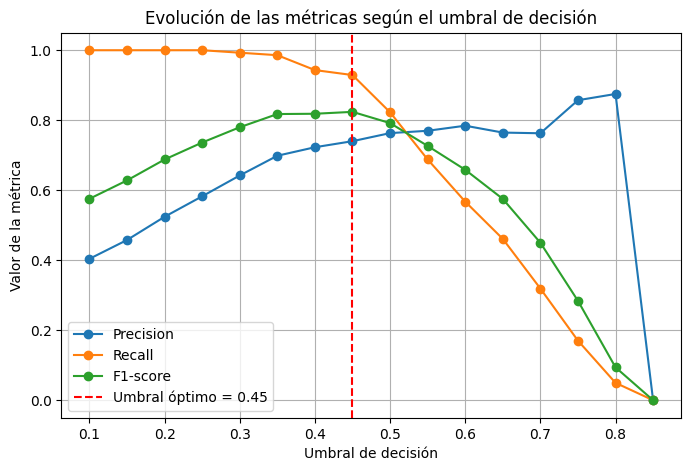

Umbral óptimo para F1: 0.45 (F1 = 0.824)


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Rango de umbrales de decisión
thresholds = np.arange(0.1, 0.9, 0.05)

# Calcular métricas para cada umbral
precisions = []
recalls = []
f1_scores = []

for t in thresholds:
    y_pred = (y_proba > t).astype(int)
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Encontrar el mejor umbral
best_t = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

# Graficar
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1-score', marker='o')
plt.axvline(best_t, color='red', linestyle='--', label=f'Umbral óptimo = {best_t:.2f}')
plt.title('Evolución de las métricas según el umbral de decisión')
plt.xlabel('Umbral de decisión')
plt.ylabel('Valor de la métrica')
plt.legend()
plt.grid(True)
plt.show()

print(f"Umbral óptimo para F1: {best_t:.2f} (F1 = {best_f1:.3f})")

Interpretación de la evolución de las métricas según el umbral de decisión

La gráfica muestra cómo cambian las tres métricas principales del modelo —precisión, recall y F1-score— a medida que se ajusta el umbral de decisión (es decir, el punto a partir del cual el modelo clasifica una observación como positiva).

* **La línea azul (precisión)** representa el porcentaje de
predicciones positivas que fueron correctas.
Se observa que la precisión aumenta al subir el umbral, porque el modelo se vuelve más exigente para clasificar como positivo, reduciendo falsos positivos.

*  **La línea naranja (recall)** muestra la capacidad del modelo para detectar todos los casos positivos reales.
Al contrario que la precisión, el recall disminuye al aumentar el umbral, ya que el modelo deja de identificar algunos casos positivos (aumentan los falsos negativos).

* **La línea verde (F1-score)** combina precisión y recall en una sola métrica, buscando el mejor equilibrio entre ambas.
En el gráfico, el F1 alcanza su valor máximo cerca del umbral 0.45 (indicado por la línea roja discontinua).

Este punto representa el umbral óptimo: el modelo logra el mejor balance entre detectar correctamente los casos positivos y mantener una buena precisión en sus predicciones.

En resumen, ajustar el umbral a 0.45 mejora el rendimiento global del modelo, haciéndolo más sensible sin sacrificar demasiado la exactitud.
Esto es especialmente útil en problemas donde es más importante detectar todos los casos relevantes (por ejemplo, fraudes, enfermedades, alertas, etc.) que evitar algunos falsos positivos.

## Feature importance con Random Forest ##

Ya que en el proyecto el modelo que mejor funcionó fue Random Forest, este modelo nos da directamente las variables más influyentes.


In [15]:
import pandas as pd
import numpy as np

# 1. Obtener importancias desde el RandomForest del pipeline
importances = best_rf.named_steps['clf'].feature_importances_

# 2. Obtener nombres de las features transformadas por el ColumnTransformer
feature_names = (
    best_rf.named_steps['preprocess']
          .get_feature_names_out()
)

# 3. Crear DataFrame ordenado
importance_df = pd.DataFrame({
    'variable': feature_names,
    'importancia': importances
}).sort_values('importancia', ascending=False)

importance_df.head(20)


,variable,importancia
9,num__Ansiedad,0.257071
12,num__Tiempo_Internet,0.152163
8,num__Autoestima,0.103790
2,num__Notas_Promedio,0.076240
1,num__Horas_Sueno,0.058375
5,num__Tiempo_Redes,0.056422
11,num__Conflictos_Familiares,0.052302
3,num__Numero_Amigos,0.048484
10,num__Depresion,0.043002
13,num__Actividad_Fisica,0.034963


El análisis de importancia de variables, realizado mediante un modelo Random Forest con balanceo de clases, revela que los factores más determinantes en la probabilidad de sufrir bullying son de naturaleza emocional y relacional. Las variables con mayor influencia fueron Ansiedad (0.257), Tiempo dedicado a Internet (0.152) y Autoestima (0.103). Estas dimensiones indican que los estudiantes con mayor vulnerabilidad emocional o con elevada exposición digital presentan un riesgo significativamente mayor de ser víctimas de acoso escolar.

Otras variables relevantes incluyen el rendimiento académico, el número de amigos, las horas de sueño y la presencia de conflictos familiares, lo que sugiere que el entorno personal y social del estudiante juega un papel fundamental en la aparición del bullying.

En contraste, variables como el género, la edad o el tipo de centro educativo muestran una influencia mínima en la predicción, lo que indica que, en este dataset, el acoso escolar no depende de características demográficas, sino de factores emocionales, sociales y de hábitos de vida.

En conjunto, estos resultados subrayan la importancia de abordar el bullying desde una perspectiva integral, que incluya la salud mental del alumnado, la calidad de sus relaciones sociales y la influencia del entorno familiar y digital.

Accedemos al modelo Random Forest dentro del pipeline y obtenemos las importancias de cada variable, es decir, cuánto contribuye cada característica a predecir la variable objetivo “sufre_bullying”:

In [16]:
best_rf.named_steps["clf"].feature_importances_


array([0.01677628, 0.05837547, 0.07624025, 0.04848382, 0.03218022,
       0.05642197, 0.0168442 , 0.03184139, 0.1037903 , 0.25707135,
       0.0430019 , 0.05230162, 0.15216335, 0.03496296, 0.00501175,
       0.00481989, 0.00485364, 0.00485965])

Realizamos un plot de la importancia de las variables para visualizarlas mejor

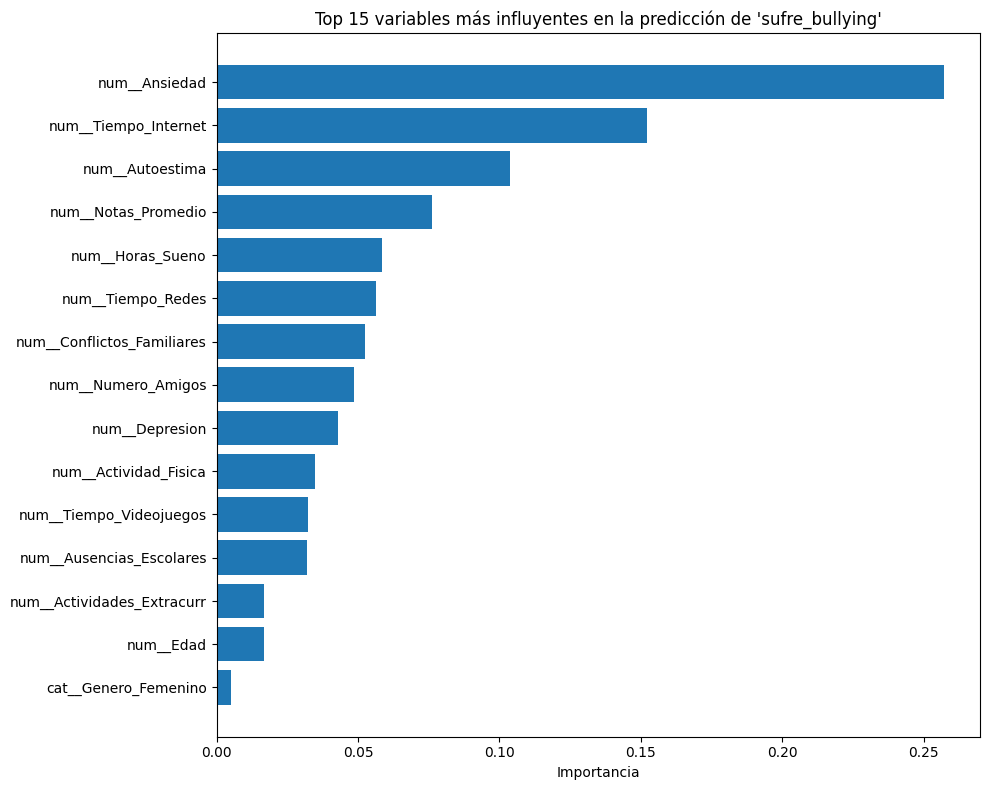

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Extraer importancias del RandomForest dentro del Pipeline
importances = best_rf.named_steps['clf'].feature_importances_

# Obtener los nombres de las variables después del preprocesamiento
# ColumnTransformer expande las variables categóricas
feature_names = best_rf.named_steps['preprocess'].get_feature_names_out()

# Crear dataframe ordenado
importance_df = pd.DataFrame({
    'variable': feature_names,
    'importancia': importances
}).sort_values('importancia', ascending=False)

# --- Plot ---
plt.figure(figsize=(10, 8))
plt.barh(importance_df['variable'][:15][::-1], 
         importance_df['importancia'][:15][::-1])
plt.xlabel("Importancia")
plt.title("Top 15 variables más influyentes en la predicción de 'sufre_bullying'")
plt.tight_layout()
plt.show()


La gráfica muestra las 15 variables más influyentes en la predicción de la variable objetivo “sufre_bullying” según el modelo Random Forest. Cada barra representa la importancia relativa de una característica dentro del modelo: cuanto mayor es la barra, mayor es el peso de esa variable para distinguir entre alumnado que sufre acoso y alumnado que no.

##### 1. Variables emocionales y psicológicas (las más influyentes) #####

Las variables con mayor importancia son Ansiedad, Tiempo en Internet y Autoestima, lo que indica que el malestar emocional y el uso intensivo de dispositivos digitales son factores estrechamente relacionados con el riesgo de sufrir acoso escolar.

Ansiedad aparece como el predictor más determinante.

Autoestima baja también destaca como un factor clave.

Esto coincide con la literatura científica: los estudiantes con mayor vulnerabilidad emocional o inseguridad suelen estar más expuestos a situaciones de victimización.

##### 2. Hábitos digitales y estilo de vida

Variables como Tiempo en Internet, Tiempo en Redes Sociales y Horas de Sueño también tienen un peso importante.

El uso intensivo de redes sociales puede aumentar la exposición a conflictos o ciberacoso.

Dormir poco se asocia con estrés, problemas emocionales y una mayor sensibilidad social.

##### 3. Aspectos académicos y escolares

Notas Promedio y Ausencias Escolares también aparecen entre las variables relevantes.
Un rendimiento más bajo o ausencias frecuentes pueden reflejar problemas previos o consecuencias del acoso.

Número de Amigos influye positivamente: menos relaciones sociales aumenta el riesgo.

##### 4. Entorno familiar y social

La presencia de Conflictos Familiares es otro factor influyente.
Los estudiantes que viven en ambientes familiares tensos o conflictivos tienen mayor probabilidad de experimentar dificultades relacionales en la escuela.

##### 5. Actividad física y otras variables de estilo de vida

La Actividad Física y el Tiempo en Videojuegos también contribuyen, aunque con menor peso relativo.
Suelen estar asociados al nivel de socialización, manejo del estrés y hábitos de ocio.

#####  6. Variables demográficas

Por último, variables como Género o Edad tienen poca influencia en comparación con las variables emocionales y sociales, lo que sugiere que en este dataset el riesgo de bullying está más ligado al contexto emocional, familiar y social que a factores demográficos.

## Conclusión 

El modelo identifica que los factores más relacionados con el **riesgo de sufrir bullying son principalmente de tipo emocional** (ansiedad, autoestima), digital/social (tiempo en internet y redes) y académico/social (notas, número de amigos, horas de sueño).
Esto respalda la idea de que la prevención del acoso escolar debe centrarse no solo en conductas visibles, sino también en el bienestar emocional, el acompañamiento familiar y el uso responsable del entorno digital.

### USO IA GENERATIVA

Para la elaboración de esta práctica se ha usado "chat-gpt". 

El primer comando que se uso fue: " asume el rol de un experto en IA, especialista en ML".
También se le han realizado preguntas como: 
1. https://chatgpt.com/s/t_691e4ac2c19c8191b772f09d8d6e2fa0
2. Interpretación de resultados: https://chatgpt.com/s/t_691e4b1a331c819183171130f7e81946
3. https://chatgpt.com/s/t_691e4d04fdc88191bed07181b7df1c58
